In [17]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

## Pré-processamento

In [2]:
df = pd.read_csv('WineQT.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [ ]:
df.drop(columns=['Id'], inplace=True)

In [7]:
df['quality'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)

In [9]:
X = df.drop("quality", axis=1)
y = df["quality"]

## Treinamento do modelo

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.70, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
ks = list(range(1, X_train_scaled.shape[0]//2, 2))
cv_scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


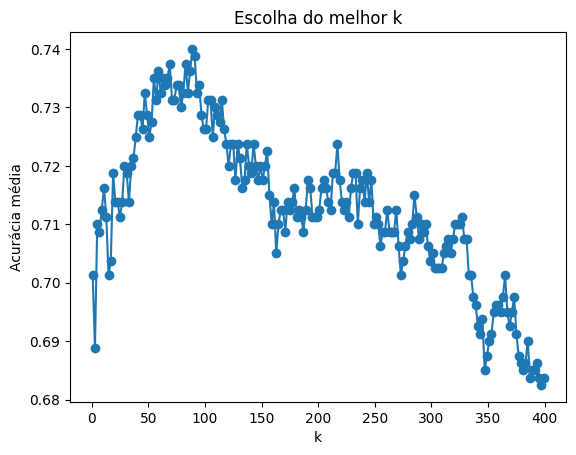

Melhor k: 89


In [36]:
plt.plot(ks, cv_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Acurácia média")
plt.title("Escolha do melhor k")
plt.show()

best_k = ks[cv_scores.index(max(cv_scores))]
print("Melhor k:", best_k)

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
test_accuracy = best_knn.score(X_test_scaled, y_test)
print("Acurácia no conjunto de teste:", test_accuracy)

Acurácia no conjunto de teste: 0.7405247813411079


In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
y_pred = best_knn.predict(X_test_scaled)

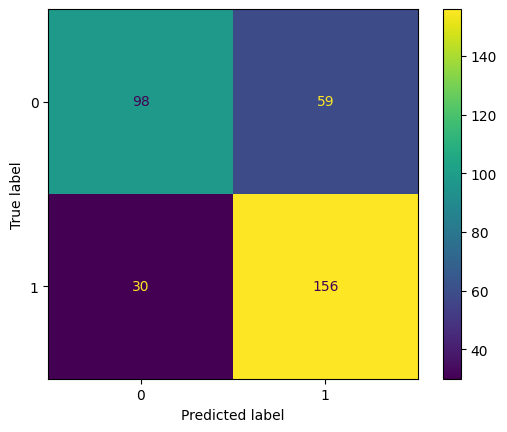

In [42]:
mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=best_knn.classes_)
disp.plot()

## Selecionando melhor atributo

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.70, stratify=y, random_state=42
)

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
knn = KNeighborsClassifier(n_neighbors=89)

In [46]:
sfs = SequentialFeatureSelector(
    knn,
    n_features_to_select="auto",
    direction='forward',
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train_scaled, y_train)
selected_features = X.columns[sfs.get_support()]
print("Atributos selecionados:", list(selected_features))

Atributos selecionados: ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']


In [47]:
X_train_sel = sfs.transform(X_train_scaled)
X_test_sel = sfs.transform(X_test_scaled)

In [49]:
knn.fit(X_train_sel, y_train)
test_acc = knn.score(X_test_sel, y_test)

print(f"Acurácia no teste (com atributos selecionados): {test_acc:.4f}")

Acurácia no teste (com atributos selecionados): 0.7522


### Matriz de confusão

In [50]:
y_pred_sel = knn.predict(X_test_sel)

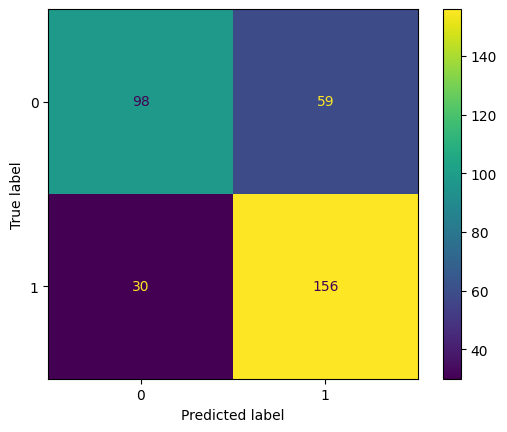

In [51]:
mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=knn.classes_)
disp.plot()